In [1]:
# Installing packages if needed
# !pip install pywavelets biosppy pandas scikit-learn ast wfdb numpy 

# Just defining some standard imports and configs I like to use when working with notebooks

from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import sys
assert sys.version_info.major == 3, 'Not running on Python 3'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# For plotting
import seaborn as sns
sns.set_context('notebook')
sns.set(style="whitegrid", font_scale=1.5)
sns.despine()

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 5]

## Problem statement

The ECG is a time series that measures the electrical activity of the heart. This is the main tool to diagnose heart diseases. Recording an ECG is simple: 3 electrodes are placed at the ends of limbs, and 6 on the anterior chest.This generates 12 time series, called leads, each corresponding to a difference in potential between a pair of electrodes.
The electrodes’ position is very important to correctly interpret the ECG. Making the mistake of inverting electrodes compromises interpretation, either because the leads do not explore the expected area (errors in the measures of hypertrophia indices, in the analysis of the ST segment), or because they generate false abnormalities (fake Q waves, error in the heart’s axis…).
Inversion errors are frequent (5% of ECGs), and only experts (cardiologists) manage to detect them. But most ECGs are not interpreted by experts: only 30% are, the rest being interpreted by nurses or general practitioners. An algorithm for automatic detection of electrode inversion is therefore paramount to the correct interpretation of ECGs and would improve the quality of diagnosis.
This project is intended to make you detect electrode inversion in an ECG. The dataset at your disposal contains ECGs from a cardiology center. An ECG will be labeled as correctly realised (0) or as inverted (1). The goal is to perform binary classification on these ECGs.

The key objective of this homework is to propose a model relevant to the task that shows good accuracy in detection of lead inversion.

## Data Analysis

Data loading from pickled file.
Data:
- The training data contains 1400 ECGs and their labels. For each ECG, the data consists of 10 seconds of recording for 12 leads, each sampled at 250Hz.
- The testing data contains 2630 ECGs.
Each input file therefore contains the ECG signal in the form (n_ecgs, n_samples=2500, n_leads=12).

We got for the training set 1400 examples of a 10 seconds ECG (2500 steps sampled at 250Hz) for the 12 leads. This 3-dimensional formulation should be quite conventient to use with ml and dl algorithms. I will load the data and check some of them.

In [2]:
import pandas as pd
import os.path
import ast
import wfdb
import numpy as np

path = 'data/ptb-xl/'
sampling_rate = 100

class_dict = {'NORM': 0,
              'LAFB': 1, 'LPFB': 1, 'IRBBB': 1, 'CLBBB': 1, 'CRBBB': 1, 'IVCD': 1, '_AVB': 1, 'WPW': 1, 'ILBBB': 1,
              'STTC': 2, 'NST_': 2, 'ISCA': 2, 'ISC_': 2, 'ISCI': 2,
              'AMI': 3, 'IMI': 3, 'LMI': 3,
              'LVH': 4, 'LAO': 4, 'LAE': 4, 'RAO': 4, 'RAE': 4,
              }


def load_raw_data(df, _sampling_rate, _path, drop):
    if _sampling_rate == 100:
        data = [wfdb.rdsamp(_path+f) for i, f in enumerate(df.filename_lr) if i not in drop]
    else:
        data = [wfdb.rdsamp(_path+f) for i, f in enumerate(df.filename_hr) if i not in drop]
    data = [signal for signal, meta in data]
    return np.array(data)


ds_x = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
y_train_raw = [max(ast.literal_eval(code), key=ast.literal_eval(code).get)
           if max(ast.literal_eval(code).values()) > 20 else 'NONE'
           for code in ds_x.scp_codes]

# Cleaning-up unknown labels
to_drop = [i for i, c in enumerate(y_train_raw) if c not in class_dict]

x_train_raw = load_raw_data(ds_x, sampling_rate, path, drop=to_drop)[:1400]
y_train_raw = np.array([class_dict[c] for i, c in enumerate(y_train_raw) if i not in to_drop])[:1400]
y_train_raw[y_train_raw > 0] = 1

print('Training dataset shape: {} - Training labels shape: {}'.format(
    x_train_raw.shape, y_train_raw.shape))

Training dataset shape: (1400, 1000, 12) - Training labels shape: (1400,)


Visualizing a couple of ECG in order to better understand data. As stated in the problem formulation, inversion can impact any of the leads. I do not think I should remove some leads (i think the simplification of the problem via reduction of dimensionality would only bring to loss of information)

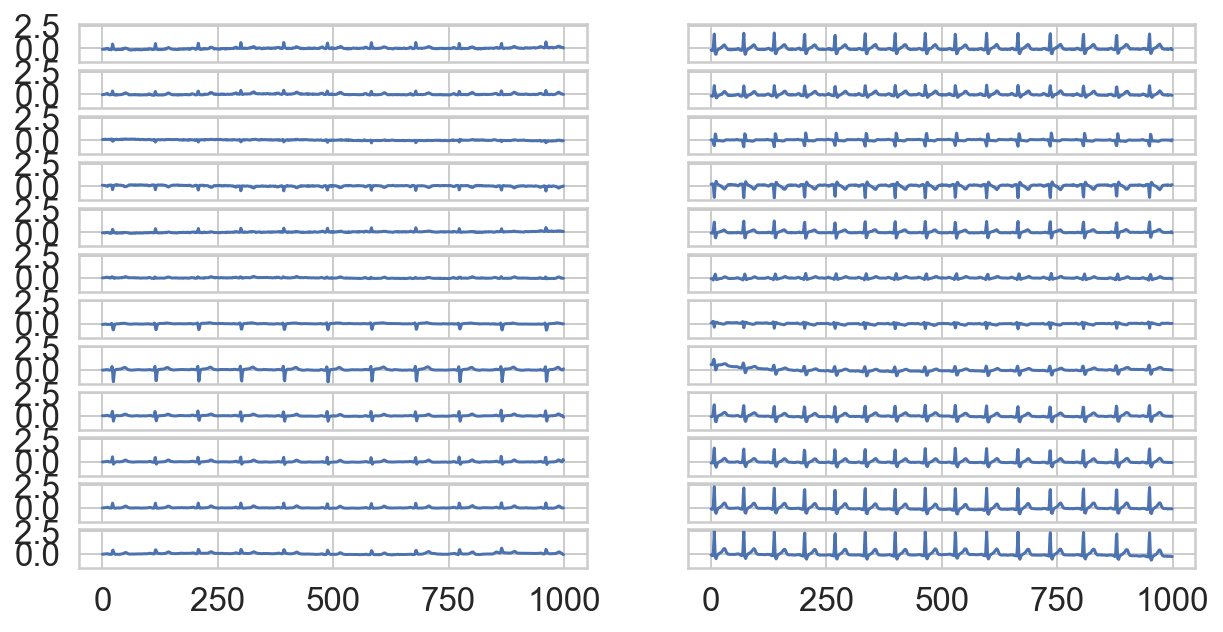

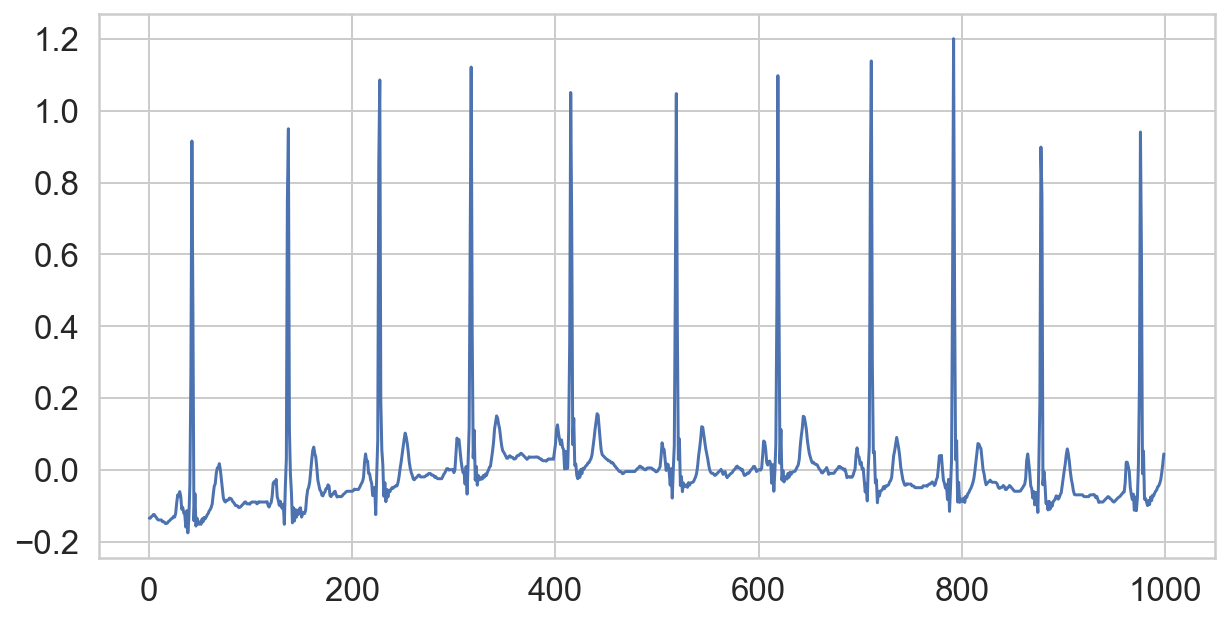

In [3]:
fig, ax = plt.subplots(x_train_raw.shape[-1], 2, sharex=True, sharey=True)
for i in range(x_train_raw.shape[-1]):
    sns.lineplot(data=x_train_raw[0, :, i], ax=ax[i, 0])
    sns.lineplot(data=x_train_raw[-1, :, i], ax=ax[i, 1])
plt.show();

sns.lineplot(data=x_train_raw[100, :, 2])
plt.show();

All the leads are correctly loaded. I am not a trained cardiologist (maybe a cardiologs soon ;) ) but the signal looks clean overall. A drift is well visible as well as some high frequency artifacts. As confirmed by mail the test set share the same noise caractheristic of the training set so I should be correct to use the same preprocessing pipeline for the two.

It is interesting to check the label distribution in order to see if there is a significant imbalance in the training set. If the dataset is unbalanced I might think about oversampling the minority class (to verify that the oversampling does not lead to an overfit on the minority data when using such a small dataset). I might also undersample the majority class or just weight the class in the loss function.

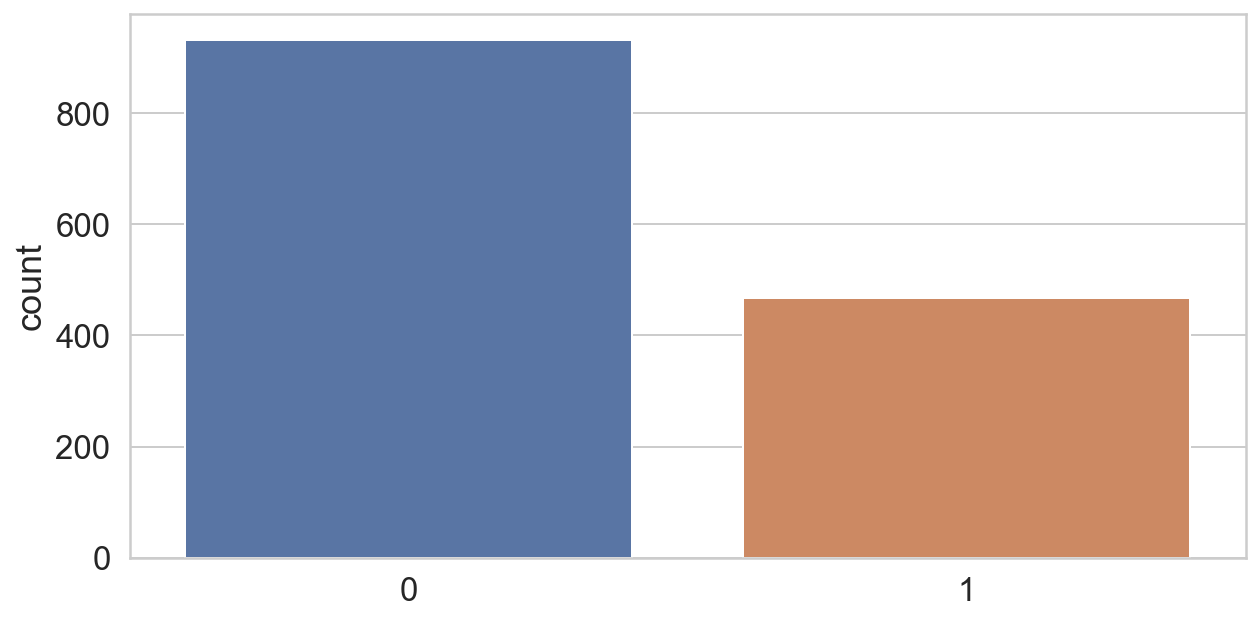

In [4]:
sns.countplot(x=y_train_raw)
plt.show();

Data seems quite balanced. For the moment I don't think I need to do more but I will need to check the final accuracy, precision and recall of the models in order to be sure that I do not need to implemnent sampling strategies

## Outline of solution

Supervised learning seems to me the way to go. I will use the training set and the given labels to train a ML/DL algorithm to predict the class of the test set. In orde to achieve good results I need to: cleanup the data, define the model, define the training strategy, tune the hyperparameters.

## Data Pre-Processing

I identified 4 pre-processing steps looking at some artcles: denoising, drift removal, resampling, normalization. 
1. For denoising and drift removal everyone seems to use a wavelet based analysis to remove high frequency components and a median filter to remove drift below 2Hz.
2. For drift removal
3. I am not sure resampling is relevant in this case since all data should be already at the same frequency of 250Hz (might obtain improvements with a lower sampling rate? it might reduce noise but lose some information, to be eventually explored). 
4. For normalization I should bring values in the range of [-1, 1], [0, 1] is also an option. I might adopt a simple normalization or a z score normalization (is it better to normalize lead by lead or use the global statics of the entire sample? to be explored if I got time)

From a quick analysis of the state-of-the-art it seems that db4 or db5 are the wavelets better suited to ecg analysis. pywavelets does suport more than 120 of them so it is not productive to spend time on the choice. I will start with db4 and I might chek db5 if i got some time remaining.  Wavelets decompose the signal in approximate and detailed coefficients. Appoximate coefficients represents low frequency components and detailed coeff represent high frequency components. I should be able to filter noise thresholding both types of coefficients. In order to find the good thresholding value I found the formula in 

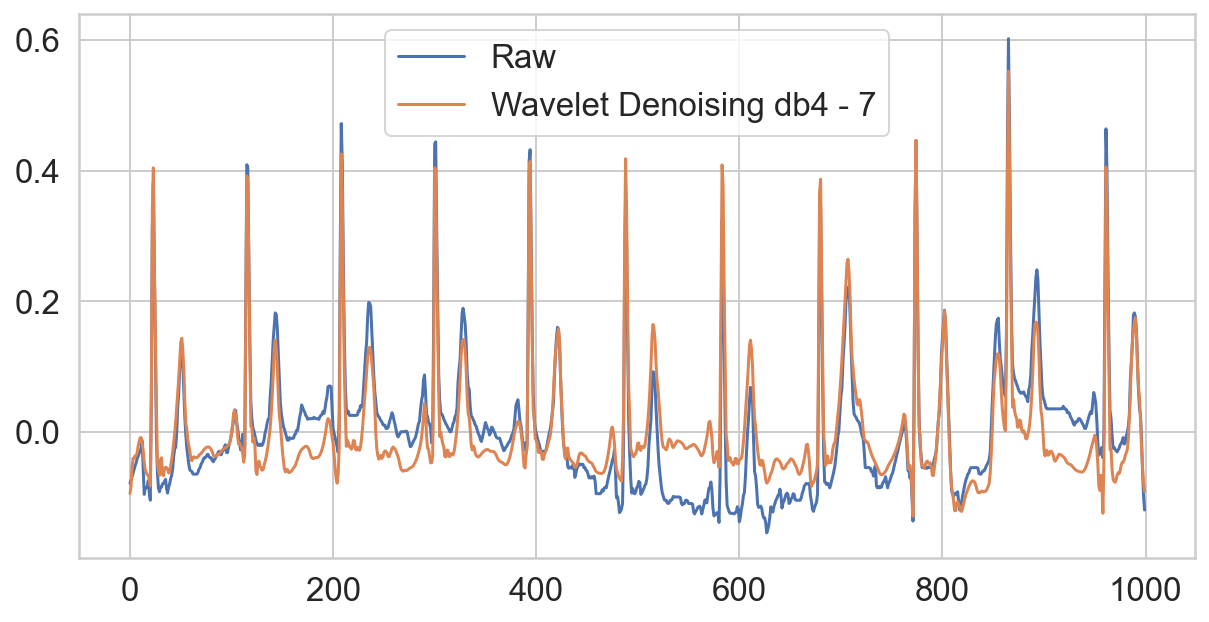

In [24]:
import pywt

def wtd(x, w, l):
    coeff = pywt.wavedec(x, w, mode="per", level=l)

    keep = []
    for i in range(len(coeff[0])):
        if i not in keep:
            coeff[0][i] = 0
            
    # standard thresholding value estimation
    sigma = np.mean(np.absolute(coeff[-1] - np.mean(coeff[-1]))) / 0.6745
    thresh = sigma * np.sqrt(2 * np.log(len(x)))
    # detailed coefficients in inverse order starting from pos 1
    coeff[1:] = (pywt.threshold(i, value=thresh, mode='hard') for i in coeff[1:])
    
    return pywt.waverec(coeff, w, mode='per')

wav = pywt.Wavelet('db4')
sns.lineplot(data=x_train_raw[0, :, 11], label='Raw')
x_train_denoised = np.zeros(x_train_raw.shape)
level = int(np.log2(0.6745 * sampling_rate / 0.5))
for s in range(x_train_raw.shape[0]):
    for der in range(x_train_raw.shape[-1]):
        x_train_denoised[s, :, der] =  wtd(x_train_raw[s, :, der], w=wav, l=level)

sns.lineplot(data=x_train_denoised[0, :, 11], label='Wavelet Denoising db4 - {}'.format(level))
plt.show();

I did not find satisfying results thresholding the low frequency components of the approximate coefficients (might be doing it wrong?) Thresholding based on the mean absolute deviation of the first detailed coefficient seems promising.


With low frequency components still present the signal is still corrupted by a baseline drift. In order to eliminate the drift I may use a passband filter with cutoff at 3Hz and 40Hz. 3Hz should be high enough to remove motion artifact without impacting the signal. 40Hz stopband should be enough to remove powersupply frequency.

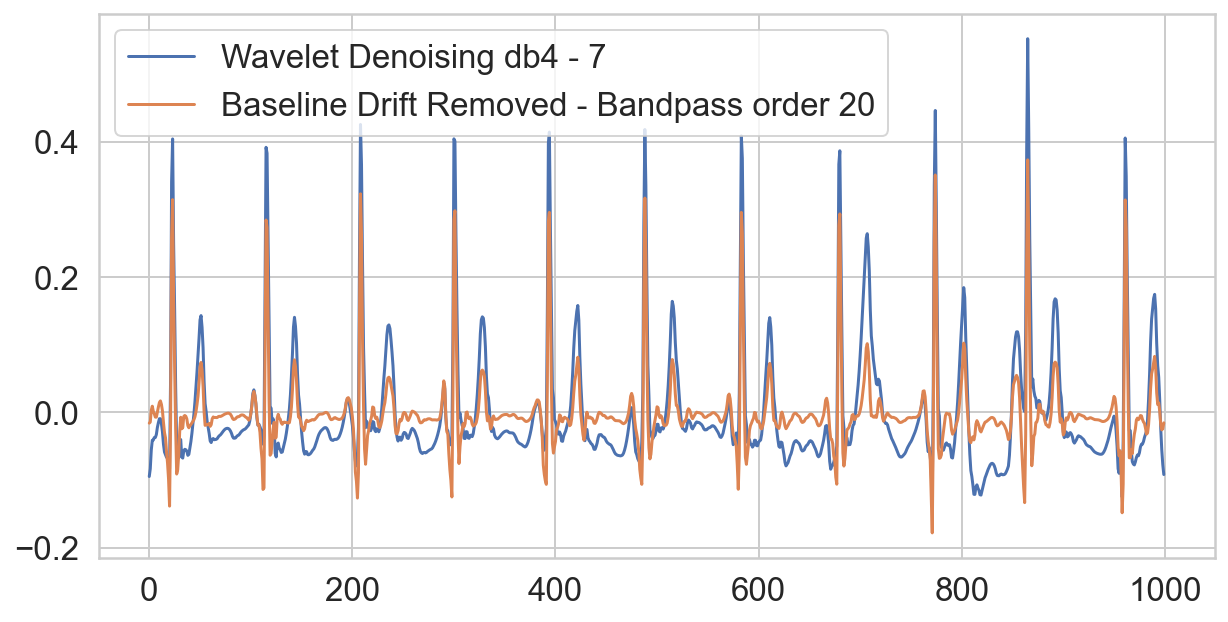

In [25]:
from biosppy.signals.tools import filter_signal

sns.lineplot(data=x_train_denoised[0, :, 11], label='Wavelet Denoising db4 - {}'.format(level))
order = int(0.2 * sampling_rate)
x_train_nodrift = np.zeros(x_train_denoised.shape)
for s in range(x_train_denoised.shape[0]):
    for der in range(x_train_denoised.shape[-1]):
        x_train_nodrift[s, :, der], _, _ = filter_signal(signal=x_train_denoised[s, :, der], ftype="FIR", band="bandpass",
                                                 order=order, frequency=[3, 40],
                                                 sampling_rate=sampling_rate)

sns.lineplot(data=x_train_nodrift[0, :, 11], label='Baseline Drift Removed - Bandpass order {}'. format(order))
plt.show();

Drift seems correctly removed. The signal seems centered and the order is not too high since I do not see strange artifacts on the waves

I do consider different normalization options. I might just do a classic (ecg - max(ecg))/(max(ecg) - min(ecg)) for a [0,1] normalization. It might be more interesting to normalize in the range[-1,1] as we can observe positive and negative tensions in the signal.  I am not quite sure the data follows a normal distribution so for the moment I will just standardise the data to have zero mean and unit variance which I might compute over the total dataset. I might normalize the signal based on global or by lead  statitics. I think I prefer to normalize by global statistics in order not to change leads relation at the timestep level.

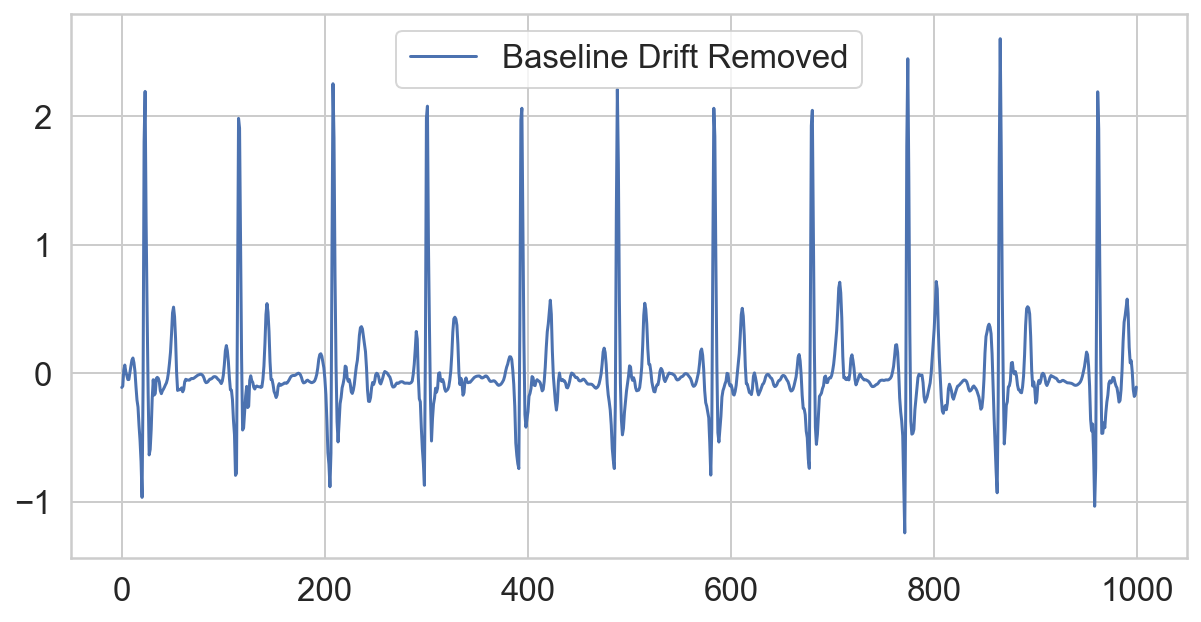

In [26]:
mean = np.mean(x_train_nodrift)
std = np.std(x_train_nodrift)

def z_score_norm(x):
    if std > 0:
        x = (x - mean) / std
    else:
        x *= 0.
    return x

x_train_centered = np.zeros(x_train_denoised.shape)
for s in range(x_train_nodrift.shape[0]):
    for der in range(x_train_nodrift.shape[-1]):
        x_train_centered[s, :, der] = z_score_norm(x_train_nodrift[s, :, der])
        
sns.lineplot(data=x_train_centered[0, :, 11], label='Baseline Drift Removed')
plt.show();

In order to supervise the models I will need to split the dataset into training and validation. I guess a 80% / 20% should be OK. I don't have a lot of data so I might use ensemble learning at the last step in order to fully exploits all data available. I will define the a model, fix the hyperparameters and train the same model 5 times on different folds. The result will be given by the weighted mean of each trained model. To have an ensemble that generalise well I can prepare the folds using the ground truth labels for stratification.

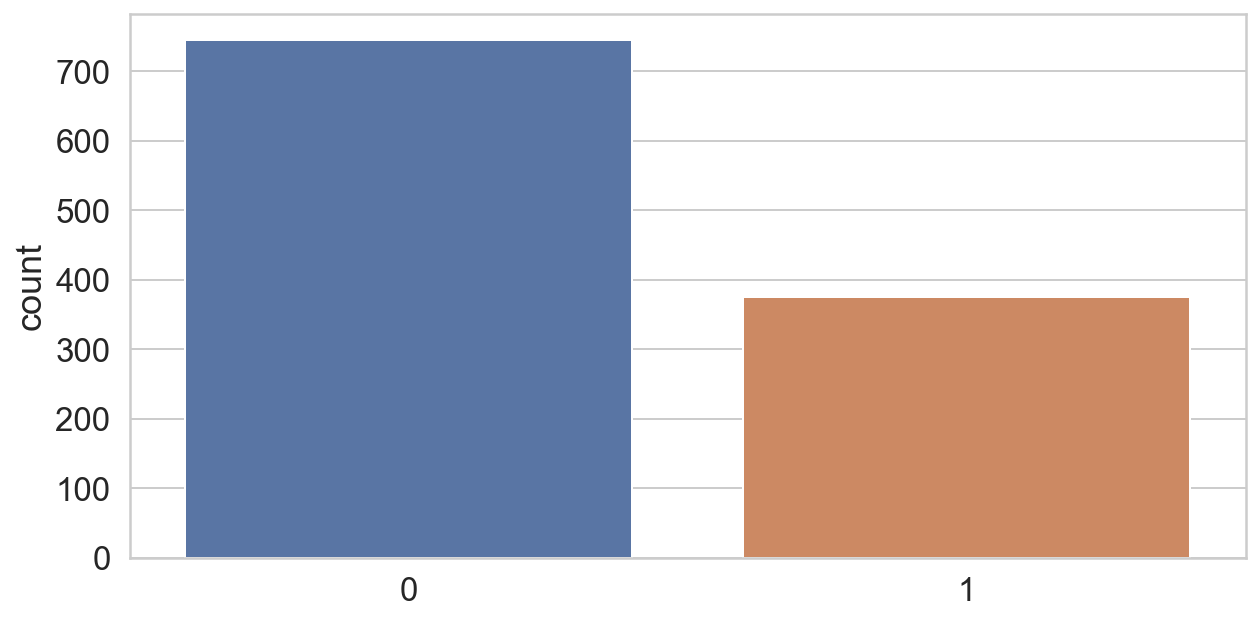

In [27]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(x_train_centered, y_train_raw)

train_folds = []
val_folds = []
for train_index, test_index in skf.split(x_train_centered, y_train_raw):
    train_folds.append((x_train_centered[train_index], y_train_raw[train_index]))
    val_folds.append((x_train_centered[test_index],  y_train_raw[test_index]))

train_ds_fold0 = train_folds[0]
val_ds_fold0 = val_folds[0]

sns.countplot(x=train_ds_fold0[1])
plt.show();

For the moment I will only work with only the first fold in order to find a working architecture. I will come back here at the end

## Models

A baseline for binary classification might be achieved with a support vector machine or a random forest classifier. These approaches might work but I do not expect high performances for high dimensional data and I need to flatten the leads dimensions in order to have a series of 1D arrays of length timestamp x leads. I think it is safe to assume the classification poroblem is not linearly separable so I will try a svm with a non linear kernel and a rf since it should be fast to compute 

In [28]:
from sklearn.svm import NuSVC

svm = NuSVC()
svm.fit(np.reshape(train_ds_fold0[0], 
                   (train_ds_fold0[0].shape[0], train_ds_fold0[0].shape[1]*train_ds_fold0[0].shape[2])
                  ), train_ds_fold0[1])
acc = svm.score(np.reshape(val_ds_fold0[0],
                           (val_ds_fold0[0].shape[0], val_ds_fold0[0].shape[1]*val_ds_fold0[0].shape[2])
                           ), val_ds_fold0[1])

print('SVM mean accuracy score: {:.2%}'.format(acc))

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(np.reshape(train_ds_fold0[0], 
                   (train_ds_fold0[0].shape[0], train_ds_fold0[0].shape[1]*train_ds_fold0[0].shape[2])
                  ), train_ds_fold0[1])
acc = rf.score(np.reshape(val_ds_fold0[0],
                           (val_ds_fold0[0].shape[0], val_ds_fold0[0].shape[1]*val_ds_fold0[0].shape[2])
                           ), val_ds_fold0[1])

print('Random Forest mean accuracy score: {:.2%}'.format(acc))

NuSVC()

SVM mean accuracy score: 70.00%


RandomForestClassifier()

Random Forest mean accuracy score: 75.00%


ML algorithms reach an accuracy of around 70%. I am quite confident I can do better using DL.

In order to properly consider the third dimension I think a deep neural network should be the way to go. For time series analysis my options would be using RNN, CNN or transformers. I guess transformers might be an overkill for the task and the limited amount of data available for training. Since the third dimensions is not a time feature but a signal feature I am more inclided to implemented a CNN based model using 1-dimensional convolutions. I would start implemnting a base convolutional network that can be further optmized. It might be interesting to combine convolution and lstm layers. 

For the deep learning framework I will use Tensorflow 2.8. Notebook can work on gpu using memory growth strategy. Tensorboard logs are stored in the ./tf_logs directory. the following cell is just for configuration.

In [29]:
debug_mode = False # Reminder to myself: set to false before sending 

# Tensorflow 2.x standard import + tensorboard
from packaging import version
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

# GPU accelerated processing if available
gpu_list = tf.config.list_physical_devices('GPU')
print("GPUs Available:")
if gpu_list:
    try:
        for gpu in gpu_list:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpu_list), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('None')

# Debugging
tf.config.run_functions_eagerly(debug_mode)
if debug_mode:
    tf.data.experimental.enable_debug_mode()
print("Eager execution: {}".format(tf.executing_eagerly()))

# Empty logs and cache
!rm -rf ./tf_logs/ 
tf.keras.backend.clear_session()

TensorFlow version: 2.8.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
GPUs Available:
None
Eager execution: True


For a first try I will build a base FCN model and to see if it has some training capabilities I can try to overfit it to training data, I will optimize validation set performance only when a stuitable architecture is found. A first network could be conv -> pooling -> dense -> classification. I might create a conv layer composed of a conv1d+batchnorm+activation and an eventual dropout to improve generalisation.

Let's define some hyperparameters.

- 50 epochs should be enough to overfit the model
- For the bartch size I do not want to start too high as it might just flatten out performances. I will put 32 for now and willl do a grid search after if I got the time. In any case batch size and learning rate should be modified togheter
- I intend to use an Adam optimizer with which I always obtained good performances on CNN, for a first try I will just use the default learning rate.

In [30]:
epochs = 50
batch_size = 32
lr = 1e-4

For the dataloader I am intered in reshuffling at each interation the training dataset and I dont care if the batch are not presented in a deterministic order. both dataset can be prefetched and cached for performance

In [31]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds_fold0)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds_fold0)

train_ds = train_ds.batch(batch_size, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                          deterministic=False
                         ).prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(len(train_ds),
                                                                                   reshuffle_each_iteration=True)
val_ds = val_ds.batch(batch_size, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                      deterministic=True
                     ).prefetch(tf.data.experimental.AUTOTUNE).cache()

I will define here a basic FCN model.

The most delicate hyperparameters are the number of convolutional filters and the kernel size. For the kernel size I should decide how many neighbords I want to include in the convolution. Considering that each timestep corresponds to 1/100 s = 10ms I could take a 100ms window using a kernel_size=10. 100ms representing a normal interval for a QRS complex (looked up on wiki, hopefully they're right...). I am not quite sur yet how many filters I should use, I guess I can start with 32/64 and ramp up if necessary, I will definetively add more filters if the model underfit.

I inserted a batchnorm layer to guide training. I expect it to behave correctly but I might remove it if I see too much smoothing on the loss functions.

The only activation functions I consider is the relu family. I dont want to introduce unnecesary complexity with a parametric relu but I could consider a leaky relu, I dont expect an huge improvements of performance with a lrelu but might try it if I got time.

Global pooling seems the good options to flatten the results and reduce complexity at the same time.

For the other hyperparameters: I prefer to use an he initialization over glorot when using CNN but it shouldnt change much tbh. The dense layer has obsiously only two neurons since it is a binary classification problem. I use a softmax activation function since the two labels are mutually exclusives (I could also use a softmax and at that point impose a threshold for classification). Crossmetric should be the correct loss function to optimize, i use its sparse version since my labels are not in a one-hot formulation.

In [32]:
fcn_model = tf.keras.Sequential()
fcn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, padding='same', kernel_initializer='he_normal',
                                     activation=None, input_shape=(1000,12)))
fcn_model.add(tf.keras.layers.BatchNormalization(axis=-1))
fcn_model.add(tf.keras.layers.LeakyReLU())
fcn_model.add(tf.keras.layers.GlobalAveragePooling1D())
fcn_model.add(tf.keras.layers.Dense(2, activation='softmax'))

fcn_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy',],)

fcn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 128)         15488     
                                                                 
 batch_normalization (BatchN  (None, 1000, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000, 128)         0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 16,258
Trainable params: 16,002
Non-traina

I usually use tensoboard to follow the training. If you want to check training logs aoutside this notebook you should find the tensoboard window in localhost at port 6006

In [33]:
%tensorboard --logdir ./tf_logs --host 0.0.0.0

Reusing TensorBoard on port 6006 (pid 82855), started 14:57:28 ago. (Use '!kill 82855' to kill it.)

First training:

In [34]:
history = fcn_model.fit(x=train_ds, validation_data=val_ds,
                        batch_size=batch_size, epochs=epochs, verbose=2,
                        callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/baseFCN',
                                                                  histogram_freq=1, update_freq='batch')],
          use_multiprocessing=True)

Epoch 1/50
35/35 - 4s - loss: 0.7046 - accuracy: 0.3821 - val_loss: 0.6790 - val_accuracy: 0.6357 - 4s/epoch - 107ms/step
Epoch 2/50
35/35 - 3s - loss: 0.6691 - accuracy: 0.7232 - val_loss: 0.6435 - val_accuracy: 0.7393 - 3s/epoch - 96ms/step
Epoch 3/50
35/35 - 3s - loss: 0.6447 - accuracy: 0.7268 - val_loss: 0.6237 - val_accuracy: 0.7071 - 3s/epoch - 99ms/step
Epoch 4/50
35/35 - 4s - loss: 0.6283 - accuracy: 0.7152 - val_loss: 0.6093 - val_accuracy: 0.6964 - 4s/epoch - 105ms/step
Epoch 5/50
35/35 - 4s - loss: 0.6161 - accuracy: 0.7143 - val_loss: 0.5985 - val_accuracy: 0.7036 - 4s/epoch - 118ms/step
Epoch 6/50
35/35 - 4s - loss: 0.6069 - accuracy: 0.7152 - val_loss: 0.5901 - val_accuracy: 0.7107 - 4s/epoch - 106ms/step
Epoch 7/50
35/35 - 3s - loss: 0.5988 - accuracy: 0.7179 - val_loss: 0.5824 - val_accuracy: 0.7143 - 3s/epoch - 98ms/step
Epoch 8/50
35/35 - 3s - loss: 0.5921 - accuracy: 0.7241 - val_loss: 0.5755 - val_accuracy: 0.7179 - 3s/epoch - 93ms/step
Epoch 9/50
35/35 - 4s - loss

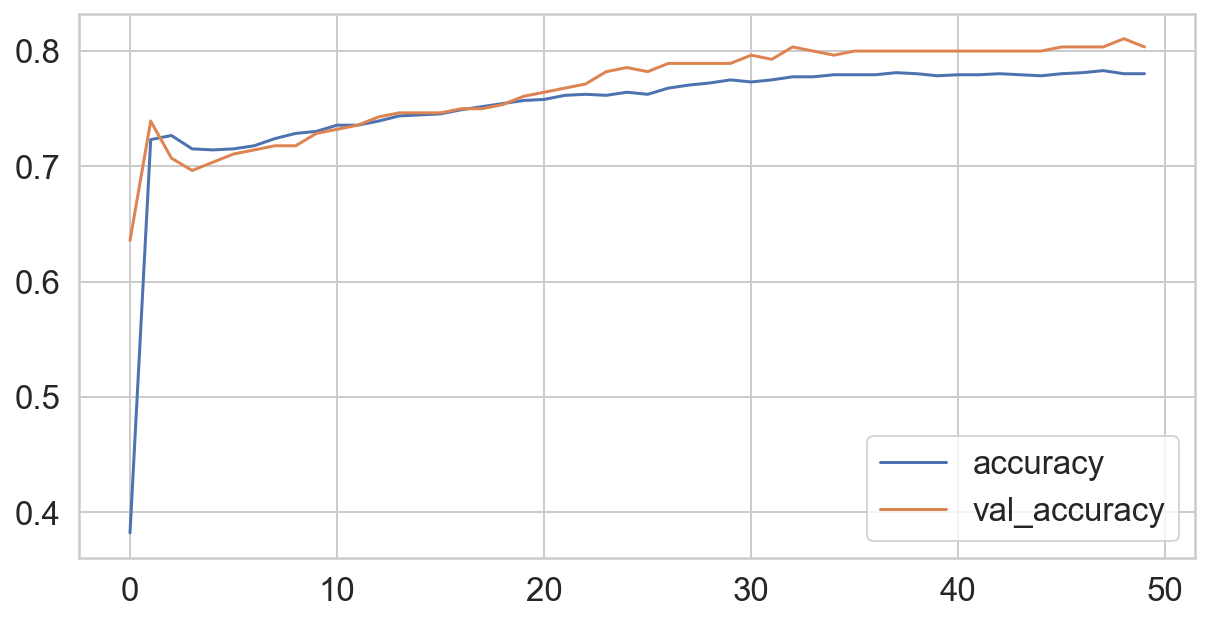

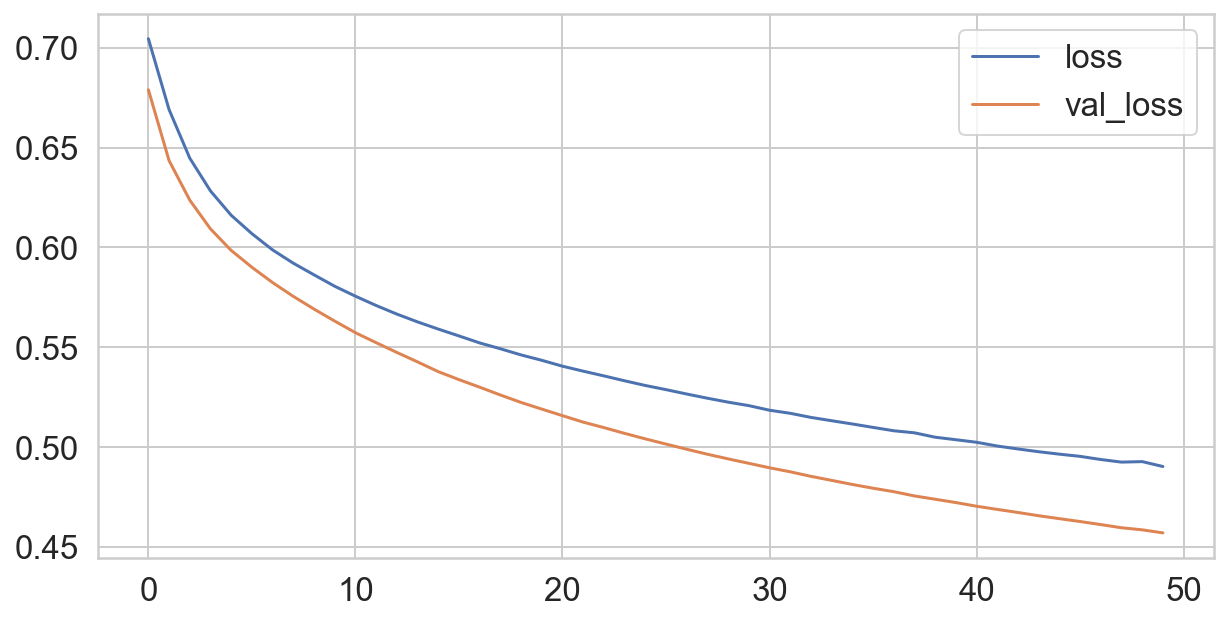

In [35]:
sns.lineplot(data=history.history['accuracy'], label='accuracy')
sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
plt.show();
sns.lineplot(data=history.history['loss'], label='loss')
sns.lineplot(data=history.history['val_loss'], label='val_loss')
plt.show();

The training actually seems pretty stable without presenting overfitting. I guess I should be able to train the model for quite a bit more epoch or just increasing the learning rate in order to achieve faster convergence. The training is stable but the results are still not great at around 80%, corresponding to a 10% increase over the random forest model.

I think increasing the model size improve performance. I might repeat two-three times the conv-batch-activation module.

In [36]:
class ConvBatchRelu(tf.keras.layers.Layer):
    def __init__(self, filters=128, kernel_size=10, inshape=None, name='ConvBatchRelu', **kwargs):
        super(ConvBatchRelu, self).__init__(name=name, **kwargs)
        if inshape:
            self.conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same',
                                               kernel_initializer='he_normal', activation=None,
                                               input_shape=inshape)
        else:
            self.conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same',
                                               kernel_initializer='he_normal', activation=None)
        self.batch = tf.keras.layers.BatchNormalization(axis=-1)
        self.act = tf.keras.layers.ReLU()
                
    @tf.function
    def call(self, inputs, training=None, **kwargs):
        x = self.conv(inputs, training=training)
        x = self.batch(x, training=training)
        x = self.act(x, training=training)
        return x

class FCN1D(tf.keras.models.Model):
    def __init__(self, n_convs=2, base_filters=128, kernel_size = 10, n_class=2, inshape=(1000,12)):
        super(FCN1D, self).__init__(self)
        self.convs = [ConvBatchRelu(base_filters, kernel_size, inshape) if i==0 
                      else ConvBatchRelu(base_filters*(2**i), kernel_size) for i in range(n_convs)]
        self.pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(n_class, activation='softmax')
        
    @tf.function
    def call(self, inputs, training=None, **kwargs):
        x = inputs
        for c in self.convs:
            x = c(x, training=training)
        x = self.pool(x, training=training)
        x = self.dense(x, training=training)
        return x


In [37]:
n_convs = [2]

for n in n_convs:
    fcn_deeper = FCN1D(n)

    fcn_deeper.compile(optimizer=tf.keras.optimizers.Adam(lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',])

    history = fcn_deeper.fit(x=train_ds, validation_data=val_ds,
                             batch_size=batch_size, epochs=50, verbose=2, 
                             callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/{}_convs_FCN'.format(n),
                                                                       histogram_freq=1, update_freq='batch')],
                             use_multiprocessing=True)

Epoch 1/50
35/35 - 23s - loss: 0.5629 - accuracy: 0.7330 - val_loss: 0.8817 - val_accuracy: 0.3393 - 23s/epoch - 659ms/step
Epoch 2/50
35/35 - 19s - loss: 0.4984 - accuracy: 0.7714 - val_loss: 0.5755 - val_accuracy: 0.7107 - 19s/epoch - 549ms/step
Epoch 3/50
35/35 - 29s - loss: 0.4690 - accuracy: 0.7830 - val_loss: 0.4779 - val_accuracy: 0.7929 - 29s/epoch - 823ms/step
Epoch 4/50
35/35 - 25s - loss: 0.4509 - accuracy: 0.7991 - val_loss: 0.4170 - val_accuracy: 0.8250 - 25s/epoch - 715ms/step
Epoch 5/50
35/35 - 22s - loss: 0.4340 - accuracy: 0.8036 - val_loss: 0.4186 - val_accuracy: 0.8143 - 22s/epoch - 642ms/step
Epoch 6/50
35/35 - 23s - loss: 0.4216 - accuracy: 0.8098 - val_loss: 0.3887 - val_accuracy: 0.8464 - 23s/epoch - 666ms/step
Epoch 7/50
35/35 - 22s - loss: 0.4162 - accuracy: 0.8080 - val_loss: 0.3812 - val_accuracy: 0.8357 - 22s/epoch - 626ms/step
Epoch 8/50
35/35 - 24s - loss: 0.4046 - accuracy: 0.8161 - val_loss: 0.3708 - val_accuracy: 0.8500 - 24s/epoch - 677ms/step
Epoch 9/

Model: "fcn1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvBatchRelu (ConvBatchRel  multiple                 16000     
 u)                                                              
                                                                 
 ConvBatchRelu (ConvBatchRel  multiple                 328960    
 u)                                                              
                                                                 
 global_average_pooling1d_1   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             multiple                  514       
                                                                 
Total params: 345,474
Trainable params: 344,706
Non-trainable params: 768
_____________________________________________________

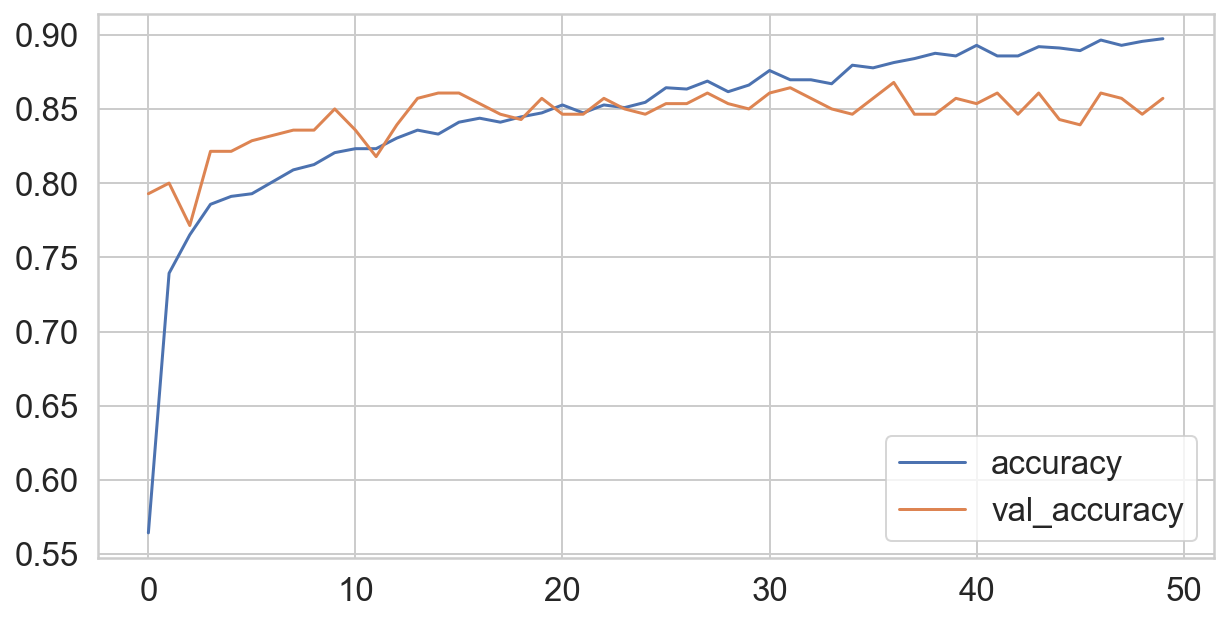

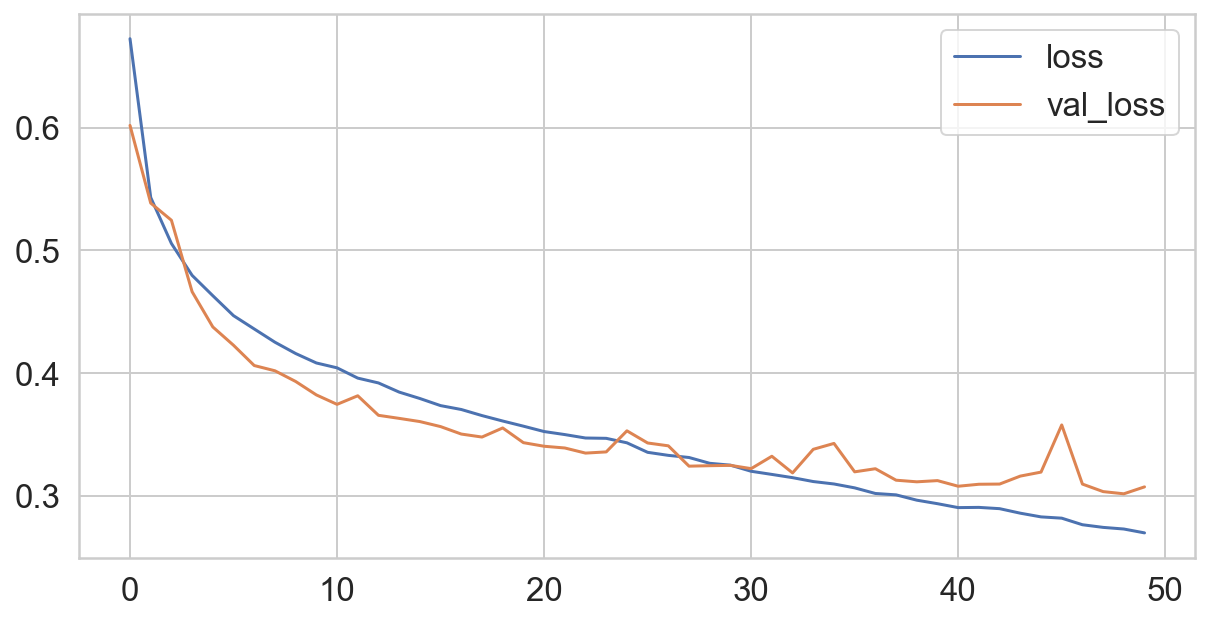

In [19]:
fcn_deeper.summary()

sns.lineplot(data=history.history['accuracy'], label='accuracy')
sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
plt.show();
sns.lineplot(data=history.history['loss'], label='loss')
sns.lineplot(data=history.history['val_loss'], label='val_loss')
plt.show();

In [ ]:
class F1Loss(tf.keras.losses.Loss):
    def __init__(self):
        super(F1Loss, self).__init__()
        self.axis = (1, 2, 3)
        self.smooth = tf.keras.backend.epsilon()

    def call(self, y_true, y_pred):
        one_hot_y_true = tf.one_hot(y_true, depth=self.n_classes)
        y_true = tf.cast(y_true, tf.float32)
        return 1. - self.dice_coefficient(y_true, y_pred)

    def dice_coefficient(self, y_true, y_pred):
        numerator = tf.reduce_sum(y_true * y_pred, axis=self.axis)
        dice = 2. * (numerator + self.smooth) / (
                tf.reduce_sum(y_true, axis=self.axis) + tf.reduce_sum(y_pred, axis=self.axis) + self.smooth)
        return tf.reduce_mean(dice)

Plotting the confusion matrix and some stats of the best model in order to better define its performances

Accuracy: 85.7% - Precision: 88.4% - Recall: 65.6%


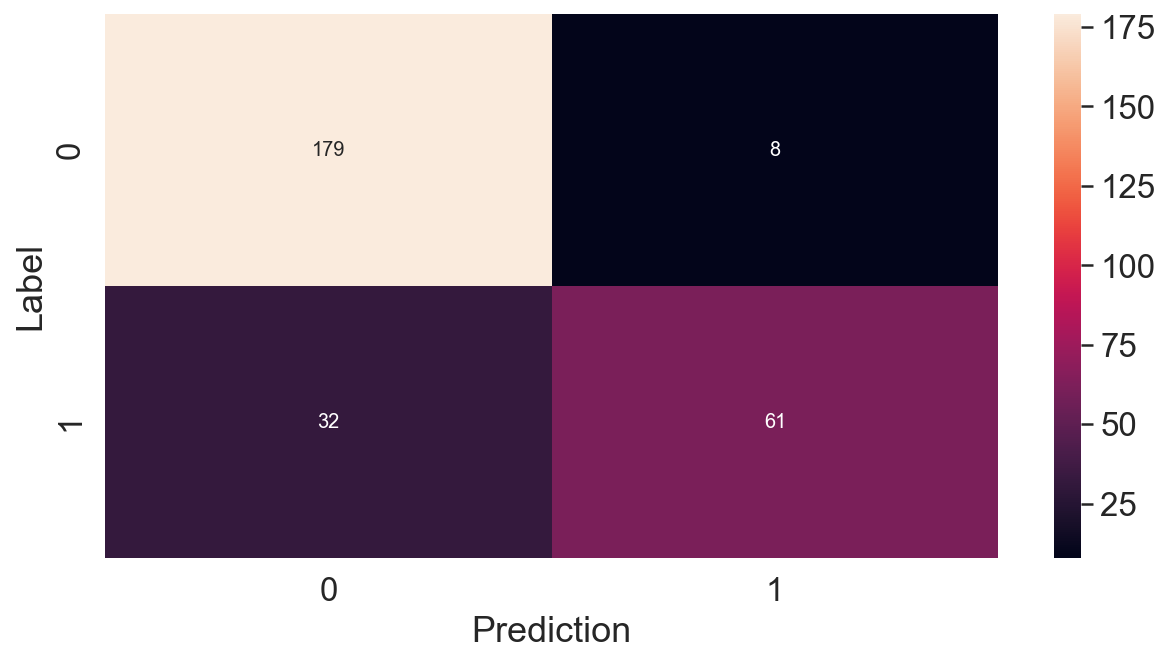

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_pred = np.argmax(fcn_deeper.predict(val_ds_fold0[0]), axis=1)
y_true = val_ds_fold0[1]

print('Accuracy: {:.1%} - Precision: {:.1%} - Recall: {:.1%}'.format(accuracy_score(y_true, y_pred),
                                                                     precision_score(y_true, y_pred),
                                                                     recall_score(y_true, y_pred)))

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show();

We observe an overall good accuracy with a precision and recall rate which are quite similar. If I had to maximise one of the two I would say that recall should be prioritized as in medical practice it is better to have a system which is able to predict all true positives with lower precision than having a precise system that is prone to miss imortant medical information

I might be able to furter improve performances tuning hyperparameters. I could do a grid search over filter, kernel, batch and lr but it could become quite time-consuming. 

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds_fold0)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds_fold0)
train_ds = train_ds.batch(batch_size*2, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                          deterministic=False
                         ).prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(len(train_ds),
                                                                                   reshuffle_each_iteration=True)
val_ds = val_ds.batch(batch_size*2, num_parallel_calls=tf.data.experimental.AUTOTUNE,
                      deterministic=True
                     ).prefetch(tf.data.experimental.AUTOTUNE).cache()

fcn_opt = FCN1D(n)

fcn_opt.compile(optimizer=tf.keras.optimizers.Adam(lr*2),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy',],)

fcn_opt.fit(x=train_ds, validation_data=val_ds,
          batch_size=batch_size, epochs=50, verbose=2, 
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tf_logs/{}_convs__batchx2_FCN'.format(n_convs),
                                                    histogram_freq=1, update_freq='batch')],
          use_multiprocessing=True)

The model I decided to keep is ...
I can use it to compute predictions on the test set

## Ensemble Strategy

## Saving

In [ ]:
test_pred = np.argmax(fcn_deeper.predict(...), axis=1)
print(test_pred[:10])

np.save('output_test.npy', test_pred)

## Notes

In [ ]:
class FCN1DLSTM(FCN1D):
    def __init__(self, base_filters=64, kernel_size = 8, n_class=2, inshape=(1000,12)):
        super(FCN1DLSTM, self).__init__(self, base_filters=64, kernel_size = 8, n_class=2, inshape=(1000,12))
        self.lstm = tf.keras.layers.LSTM(8)
        
    @tf.function
    def call(self, inputs, training=None, **kwargs):
        x = self.first(inputs, training=training)
        x = self.second(x, training=training)
        x = self.third(x, training=training)
        x = self.pool(x, training=training)
        x = self.lstm(x, training=training)
        x = self.dense(x, training=training)
        return x

In [ ]:
class ResBlock(tf.keras.layers.Layer):
    def __init__(self, filters=64, kernel_size=8, inshape=None, use_conv_short=True,
                 name='ResBlock', **kwargs):
        super(ResBlock, self).__init__(name=name, **kwargs)
        
        self.use_conv_short = use_conv_short
        if inshape:
            self.conv1 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same',
                                               kernel_initializer='he_normal', activation=None,
                                               input_shape=inshape)
        else:
            self.conv1 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding='same',
                                               kernel_initializer='he_normal', activation=None)
        self.batch1 = tf.keras.layers.BatchNormalization(axis=-1)
        self.act1 = tf.keras.layers.ReLU()
        
        self.conv2 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size-3, padding='same',
                                            kernel_initializer='he_normal', activation=None)
        self.batch2 = tf.keras.layers.BatchNormalization(axis=-1)
        self.act2 = tf.keras.layers.ReLU()
        
        self.conv3 = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size-5, padding='same',
                                            kernel_initializer='he_normal', activation=None)
        self.batch3 = tf.keras.layers.BatchNormalization(axis=-1)
        
        self.conv_short = tf.keras.layers.Conv1D(filters=filters, kernel_size=1, padding='same',
                                            kernel_initializer='he_normal', activation=None)
        self.batch_short = tf.keras.layers.BatchNormalization(axis=-1)
        
        self.act_fin = tf.keras.layers.ReLU()
        
    @tf.function
    def call(self, inputs, training=None, **kwargs):
        x = self.conv1(inputs, training=training)
        x = self.batch1(x, training=training)
        x = self.act1(x, training=training)
        
        x = self.conv2(x, training=training)
        x = self.batch2(x, training=training)
        x = self.act2(x, training=training)
        
        x = self.conv3(x, training=training)
        x = self.batch3(x, training=training)
        
        if self.use_conv_short:
            x_short = self.conv_short(inputs, training=training)
        else:
            x_short = inputs
        x_short = self.batch_short(x_short)
        
        x = x + x_short
        
        x = self.act_fin(x)
        
        return x
    
class ResNet1D(FCN1D):
    def __init__(self, base_filters=64, kernel_size = 8, n_class=2, inshape=(1000,12)):
        super(ResNet1D, self).__init__(self, base_filters=64, kernel_size = 8, n_class=2, inshape=(1000,12))
        self.first = ResBlock(base_filters, kernel_size, inshape, True)
        self.second = ResBlock(base_filters * 2, kernel_size, inshape, True)
        self.third = ResBlock(base_filters * 2, kernel_size, inshape, False)
        

In [ ]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters=64, kernel_size=16, use_final_conv=True, use_final_pooling=True,
                 name='ConvBlock', **kwargs):
        super(ConvBlock, self).__init__(name=name, **kwargs)
        self.use_final_conv = use_final_conv
        self.use_final_pooling = use_final_pooling

        self.batch_1 = tf.keras.layers.BatchNormalization(axis=-1)
        self.act_1 = tf.keras.layers.ReLU()
        self.drop_1 = tf.keras.layers.Dropout(0.5)
        self.conv_1 = tf.keras.layers.Conv1D(filters, kernel_size=kernel_size, padding='same', 
                                             kernel_initializer='he_normal', activation=None)
        self.batch_2 = tf.keras.layers.BatchNormalization(axis=-1)
        self.act_2 = tf.keras.layers.ReLU()
        self.drop_2 = tf.keras.layers.Dropout(0.5)
        self.conv_2 = tf.keras.layers.Conv1D(filters, kernel_size=kernel_size, padding='same',
                                             kernel_initializer='he_normal', activation=None)
        
        self.pool_fin = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)
        
        self.conv_par = tf.keras.layers.Conv1D(filters, kernel_size=1)
        self.pool_par = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)
        
    @tf.function
    def call(self, inputs, training=None, **kwargs):
        if self.use_final_conv:
            xshort = self.conv_par(inputs, training=training)
        else:
            xshort = inputs
        
        x1 = self.batch_1(inputs, training=training)
        x1 = self.act_1(x1, training=training)
        x1 = self.drop_1(x1, training=training)
        x1 = self.conv_1(x1, training=training)
        x1 = self.batch_2(x1, training=training)
        x1 = self.act_2(x1, training=training)
        x1 = self.drop_2(x1, training=training)
        x1 = self.conv_2(x1, training=training)
        
        if self.use_final_pooling:
            x1 = self.pool_fin(x1, training=training)
            x2 = self.pool_par(xshort, training=training)
        else:
            x2 = xshort
        
        return x1 + x2

        
class ResNet1DPlus(tf.keras.models.Model):
    def __init__(self, base_filters=64, kernel_size = 16, n_class=2, inshape=(1000,12)):
        super(ResNet1DPlus, self).__init__(self)

        '-----------------------'
        self.conv_pre = tf.keras.layers.Conv1D(base_filters, kernel_size=kernel_size, padding='same', 
                                               kernel_initializer='he_normal', activation=None,
                                               input_shape=inshape)
        self.batch_pre = tf.keras.layers.BatchNormalization(axis=-1)
        self.act_pre = tf.keras.layers.ReLU()
        '-----------------------'
        self.conv_l1 = tf.keras.layers.Conv1D(base_filters, kernel_size=kernel_size, padding='same',
                                              kernel_initializer='he_normal', activation=None)
        self.batch_l1 = tf.keras.layers.BatchNormalization(axis=-1)
        self.act_l1 = tf.keras.layers.ReLU()
        self.drop_l1 = tf.keras.layers.Dropout(0.5)
        self.conv_l2 = tf.keras.layers.Conv1D(base_filters, kernel_size=kernel_size, padding='same', 
                                              kernel_initializer='he_normal', activation=None)
        self.pool_l1 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)
        
        self.pool_r1 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)
        '-----------------------'
        self.conv_block1 = ConvBlock(filters=base_filters * 1, kernel_size=kernel_size,
                                     use_final_conv=False, use_final_pooling=False)
        self.conv_block2 = ConvBlock(filters=base_filters * 1, kernel_size=kernel_size,
                                     use_final_conv=False, use_final_pooling=True)
        self.conv_block3 = ConvBlock(filters=base_filters * 1, kernel_size=kernel_size,
                                     use_final_conv=False, use_final_pooling=False)
        self.conv_block4 = ConvBlock(filters=base_filters * 1, kernel_size=kernel_size,
                                     use_final_conv=False, use_final_pooling=True)
        self.conv_block5 = ConvBlock(filters=base_filters * 2, kernel_size=kernel_size,
                                     use_final_conv=True, use_final_pooling=False)
        self.conv_block6 = ConvBlock(filters=base_filters * 2, kernel_size=kernel_size,
                                     use_final_conv=False, use_final_pooling=True)
        self.conv_block7 = ConvBlock(filters=base_filters * 2, kernel_size=kernel_size,
                                     use_final_conv=False, use_final_pooling=False)
        self.conv_block8 = ConvBlock(filters=base_filters * 2, kernel_size=kernel_size,
                                     use_final_conv=False, use_final_pooling=True)
        self.conv_block9 = ConvBlock(filters=base_filters * 3, kernel_size=kernel_size,
                                     use_final_conv=True, use_final_pooling=False)
        self.conv_block10 = ConvBlock(filters=base_filters * 3, kernel_size=kernel_size,
                                      use_final_conv=False, use_final_pooling=True)
        self.conv_block11 = ConvBlock(filters=base_filters * 3, kernel_size=kernel_size,
                                      use_final_conv=False, use_final_pooling=False)
        self.conv_block12 = ConvBlock(filters=base_filters * 3, kernel_size=kernel_size,
                                      use_final_conv=False, use_final_pooling=True)
        self.conv_block13 = ConvBlock(filters=base_filters * 4, kernel_size=kernel_size,
                                      use_final_conv=True, use_final_pooling=False)
        self.conv_block14 = ConvBlock(filters=base_filters * 4, kernel_size=kernel_size,
                                      use_final_conv=False, use_final_pooling=True)
        self.conv_block15 = ConvBlock(filters=base_filters * 4, kernel_size=kernel_size,
                                      use_final_conv=False, use_final_pooling=False)
        '-----------------------'
        self.batch_final = tf.keras.layers.BatchNormalization(axis=-1)
        self.act_final = tf.keras.layers.ReLU()
        self.f = tf.keras.layers.Flatten()
        self.dense_final = tf.keras.layers.Dense(n_class, activation='softmax')
        

    @tf.function()
    def call(self, inputs, training=None):
        x = self.conv_pre(inputs, training=training)
        x = self.batch_pre(x, training=training)
        x_pre = self.act_pre(x, training=training)
        
        x_branch_l = self.conv_l1(x_pre, training=training)
        x_branch_l = self.batch_l1(x_branch_l, training=training)
        x_branch_l = self.act_l1(x_branch_l, training=training)
        x_branch_l = self.drop_l1(x_branch_l, training=training)
        x_branch_l = self.conv_l2(x_branch_l, training=training)
        x_branch_l = self.pool_l1(x_branch_l, training=training)
        
        x_branch_r = self.pool_r1(x_pre, training=training)
                
        x_in = x_branch_l + x_branch_r
        
        x_conv = self.conv_block1(x_in, training=training)
        x_conv = self.conv_block2(x_conv, training=training)
        x_conv = self.conv_block3(x_conv, training=training)
        x_conv = self.conv_block4(x_conv, training=training)
        x_conv = self.conv_block5(x_conv, training=training)
        x_conv = self.conv_block6(x_conv, training=training)
        x_conv = self.conv_block7(x_conv, training=training)
        x_conv = self.conv_block8(x_conv, training=training)
        x_conv = self.conv_block9(x_conv, training=training)
        x_conv = self.conv_block10(x_conv, training=training)
        x_conv = self.conv_block11(x_conv, training=training)
        x_conv = self.conv_block12(x_conv, training=training)
        x_conv = self.conv_block13(x_conv, training=training)
        x_conv = self.conv_block14(x_conv, training=training)
        x_conv = self.conv_block15(x_conv, training=training)
        
        x_final = self.batch_final(x_conv, training=training)
        x_final = self.act_final(x_final, training=training)
        x_final = self.f(x_final)
        x_final = self.dense_final(x_final, training=training)
        
        return x_final


In [ ]:
def get_model(inshape, base_filters, dense_filters, n_convs = 3, n_dense = 2, ):

    model = tf.keras.Sequential()
    m = 1
    for i in range(n_convs):
        if i == 0:
            model.add(tf.keras.layers.Conv1D(base_filters * m, 3, padding='same',
                                             activation='relu', input_shape=inshape))
        else:
            model.add(tf.keras.layers.Conv1D(base_filters * m, 3, padding='same',
                                             activation='relu'))
        model.add(tf.keras.layers.BatchNormalization(axis=-1))
        model.add(tf.keras.layers.MaxPooling1D())
        m += m
    model.add(tf.keras.layers.Flatten())
    if n_dense > 1:
        m = 2 * (n_dense - 1)
    else:
        m = 1
    for i in range(n_dense):
        model.add(tf.keras.layers.Dense(dense_filters * m, activation='relu'))
        m = m // 2
    model.add(tf.keras.layers.Dense(2))

    model.summary()

    return model

#model = get_model((1000, 12), 128, 8, 1, 1)

opt = tf.keras.optimizers.Adam(learning_rate=initial_lr)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric_fn = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
HP_EPOCHS = hp.HParam('epochs', hp.Discrete([200]))
HP_BATCH = hp.HParam('batch', hp.Discrete([4]))
HP_LR = hp.HParam('initial_lr', hp.Discrete([1e-6]))
HP_FILTERS = hp.HParam('base_filters', hp.Discrete([64]))
HP_DENSEFILTERS = hp.HParam('dense_filters', hp.Discrete([16]))
HP_N_CONV = hp.HParam('n_conv_filters', hp.Discrete([2]))
HP_N_DENSE = hp.HParam('n_dense_filters', hp.Discrete([3]))

session_num = 0
run_name = 'run'

def hyper_parameters_config():
    for e in HP_EPOCHS.domain.values:
        for lr in HP_BATCH.domain.values:
            for a in HP_LR.domain.values:
                for bf in HP_FILTERS.domain.values:
                    for d in HP_DENSEFILTERS.domain.values:
                        for nc in HP_N_CONV.domain.values:
                            for nd in HP_N_DENSE.domain.values:
                                yield {
                                    HP_EPOCHS: e,
                                    HP_BATCH: lr,
                                    HP_LR: a,
                                    HP_FILTERS: bf,
                                    HP_DENSEFILTERS: d,
                                    HP_N_CONV: nc,
                                    HP_N_DENSE: nd,
                                }

for hparams in hyper_parameters_config():
    run_name = 'run-{}'.format(session_num)
    print('\n\n--- Starting trial: {}'.format(run_name))
    print({h.name: hparams[h] for h in hparams})

    run_logdir = 'tf_logs/hparam_tuning/' + run_name
    summary_writer = tf.summary.create_file_writer(run_logdir)

    with summary_writer.as_default():
        hp.hparams(hparams)
        # model = get_model((1000, 12), hparams[HP_FILTERS], hparams[HP_DENSEFILTERS], hparams[HP_N_CONV], hparams[HP_N_DENSE])
        
        # model = FCN1D()
        model = FCN1DLSTM(hparams[HP_FILTERS], hparams[HP_DENSEFILTERS])
        # model = ResNet1D()
        # model = ResNet1DPlus(hparams[HP_FILTERS], hparams[HP_DENSEFILTERS])
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy',],)

        model.fit(x=train_ds, validation_data=val_ds,
                  batch_size=batch_size, epochs=hparams[HP_EPOCHS], verbose=2, 
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, verbose=1),
                             tf.keras.callbacks.TensorBoard(log_dir=run_logdir,
                                                            histogram_freq=1, update_freq='batch')],
                  use_multiprocessing=True)
        
        model.summary()


    session_num += 1